# Analyse Twitter Archiv

Gliederung:

- Imports
- Funktionen
    - Vorbereitung
    - Analyse Aktivität
    - Analyse Inhalte
- Resultate
    - Patrick Karpiczenko (Comedian)
    - Andri Silberschmidt (Politiker)
    - Patrizia Laeri (Journalistin)
    - Emma Hodcroft (Virologin)
- Quellen
- Appendix

## Imports

In [3]:
import pandas as pd

In [4]:
import os, re, sys

In [5]:
import datetime, pytz, json
from dateutil.tz import tzlocal

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.cm as cm

from collections import Counter

from nltk.cluster import GAAClusterer
import nltk.corpus
from nltk import decorators
import nltk.stem

## Funktionen

### Vorbereitung

#### Tweets laden

In [6]:
def load_tweets_from_js(js_file):
    with open(js_file, "r") as f:
        data = f.read()
        data = data.replace("window.YTD.tweets.part0 = ", "")
        tweets = json.loads(data)
        for tweet in tweets:
            ts = datetime.datetime.strptime(
                tweet["tweet"]["created_at"], "%a %b %d %H:%M:%S +0000 %Y"
            )
            ts = ts.replace(tzinfo=pytz.utc)
            ts = ts.astimezone(tzlocal())
            tweet["timestamp"] = ts
        print("Loaded %d tweets" % len(tweets))
        return tweets

####  Dictionary bauen, das die genutzten Daten extrahiert aus dem Twitter-Json

In [7]:
def create_custom_dictionary(tweets, keys_list):
    """
    in: tweets (created by load_tweets_from_json), and keys_list 
    (has to be listed by hand: which dict values 
    should appear in the custom dict as well, in order to be analyzed later?
    """
    
    tweet_dict = {key:[] for key in keys_list}
    
    # populates Dictionary of Tweets with the important values, as listed in Keys_list
    for item in tweets:
    
        for key in keys_list:
            value = item["tweet"].get(key)
            tweet_dict[key].append(value)

            
    # Zwei neue Keys im Dictionary angelegt für Reply und Retweet (T/F)
    tweet_dict['reply'] = []
    tweet_dict['retweet'] = []
    
    
    # Keys befüllt mit (T/F für Retweet oder Reply)
    for item in tweet_dict["full_text"]:
        reply = item.startswith("@")
        tweet_dict["reply"].append(reply)
        retweet = item.startswith("RT")
        tweet_dict["retweet"].append(retweet)
        
    
    return tweet_dict

#### Dataframe bauen aus den Tweets

In [8]:
def create_pandas_dataframe(tweet_dict):
    
    """
    In: tweet_dict (the custom dictionary with keys_list entries created with create_custom_dictionary)
    Out: a clean dataframe with these values
        index set to datetime
        additional column orig which is TRUE if it is neither reply nor retweet
    """
    
    df = pd.DataFrame(tweet_dict)
    
    # Strings in Integers umwandeln, nach Spalte 
    df["favorite_count"]= df['favorite_count'].astype(int)
    df["retweet_count"]= df['retweet_count'].astype(int)

    # Dataframe sortieren nach Datum (über DateTime)
    df["datetime"] = pd.to_datetime(df["created_at"])
    df = df.sort_values("datetime")
    
    # Index in Datetime ändern, andere Date-Spalten droppen
    df.index = pd.to_datetime(df.datetime)
    df = df.drop(['created_at', 'datetime'], axis=1)
    
    
    #Neue Spalte für "orig"inale Tweets, die weder Reply oder Retweet sind
    df["orig"] = np.where( (df['reply']== False ) & (df["retweet"]== False), True, False)
    
    return df
    

### Analyse Aktivität

#### Verschiedene Analysen des Dataframes, Tabellen und Plots werden gespeichert

In [9]:
def analysis_and_save(df,name):
    """
    Function to save overview_dataframe and analysis lists and pictures

    In: df, as produced by create_pandas_dataframe and name of the person tweeting
    
    
    Out: (all names beginning with name of person)
        csv:
            - df
            - tweets_per_month
            - tweets_per_day
            - top tweets 
            
            
         plots:
            (- tweets_per_month_figure - #commented away
            (- tweets_per_day_figure #commented away
            - tweets_per_day_overall: Grafik mit 5 subplots für Tweets, Retweets, Replies, N°Likes, N°retweets
    
    """
    # First, Dataframes of aggregates/Top10 are created
    
    tweets_per_month = df.groupby(pd.Grouper(freq='M')).sum() 
    tweets_per_day = df.groupby(pd.Grouper(freq='d')).sum()
    top10_retweet_count = df.sort_values('retweet_count', ascending=False).head(10)
    top10_favorite_count = df.sort_values('favorite_count', ascending=False).head(10)
    
    # Then, all of them are saved as CSV files
    
    df.to_csv(str(name)+'_tweetlist.csv') 
  
    tweets_per_month.to_csv(str(name)+"_tweets_per_month.csv")
    tweets_per_day.to_csv(str(name)+"_tweets_per_day.csv")
    top10_retweet_count.to_csv(str(name)+"_top10_retweet_count.csv")
    top10_favorite_count.to_csv(str(name)+"_top10_favorite_count.csv")
    
    
    # Then, plots are created from these dataframes and saved, as png, could be changed into pdf or others
    
    #tweets_per_month_figure = tweets_per_month.plot(title="Tweets pro Monat").get_figure()
    #tweets_per_month_figure.savefig(str(name)+"_tweets_per_month_figure.png")
     
    #tweets_per_day_figure = tweets_per_day.plot(title="Tweets pro Tag").get_figure()
    #tweets_per_day_figure.savefig(str(name)+"_tweets_per_day_figure.png")
    
    # Zusammenfassungs-Figure, vielleicht wäre die allein genug
    
    tweets_per_day_overall = tweets_per_day.plot(subplots=True, layout=(3,2), figsize = (12,12), 
                                                 title="Tweets (original, replies, retweets), favourite count (wie viele likes) und retweet count, pro Tag")
    plt.savefig(str(name)+"_tweets_per_day_5in1_figure.png")
    

#### Tweets nach Day of Week und Time of Day - Darstellung über die Zeit hinweg als Heatmap


In [41]:
def dataframe_days_months_heatmap(tweets,name):
    
    """
    Eine Heatmap der Tweet-Aktivitäten, zusammengefasst nach Monat/Jahr, zb. 2022-01, 2022-02, etc.
    - für jeden Monat sieht man, was die aktivisten Wochentage waren
    
    
    
    In: tweets einer Person
    Out: Pandas heatmap wird angezeigt (nicht gespeichert)
    
    """
    
    data = {}
    dow = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

    for tweet in tweets:
        weekday = tweet["timestamp"].strftime("%A") # extracts weekday
        iso_yr, iso_wk, iso_wkday = tweet["timestamp"].isocalendar()
        # key = str(iso_yr) + "-" + str(iso_wk)
        key = tweet["timestamp"].strftime("%Y-%m")
        if key not in data:
            data[key] = Counter()
            
#Counter is an unordered collection where elements are stored as Dict keys and their count as dict value. 
#Counter elements count can be positive, zero or negative integers. 
            
        else: 
            data[key][weekday] += 1
    #print(json.dumps(data, indent=2))
    
    
    xx = pd.DataFrame(data)
    xx = xx.transpose()
    xx = xx.sort_index(axis=0)
    xx = xx[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]
    xx = xx.fillna(0)
    xx = xx.astype(int)
     

    df_heatmap = xx.style.background_gradient(cmap='coolwarm')

    df_heatmap.to_excel(str(name)+"_heatmap_days.xlsx")



In [42]:
def dataframe_hours_months_heatmap(tweets,name):
    
    """
    Eine Heatmap der Tweet-Aktivitäten, zusammengefasst nach Monat/Jahr, zb. 2022-01, 2022-02, etc.
    - für jeden Monat sieht man, was die aktivisten Wochentage waren
    
    
    
    In: tweets einer Person
    Out: Pandas heatmap wird angezeigt (nicht gespeichert)
    
    """
    
    # Get the # hour for each tweet
    data = {}
    #hours = []
    #for tweet in tweets:
    #    hours.append(tweet["timestamp"].hour) # macht eine lange liste mit Stunde je Tweet
        
    months = {}
    for tweet in tweets:
        hour = tweet["timestamp"].strftime("%H") # extracts hour
        #iso_yr, iso_wk, iso_wkday = tweet["timestamp"].isocalendar()
        # key = str(iso_yr) + "-" + str(iso_wk)
        key = tweet["timestamp"].strftime("%Y-%m")
        if key not in months:
            months[key] = Counter()
        else: 
            months[key][hour] += 1
            
#Counter is an unordered collection where elements are stored as Dict keys and their count as dict value. 
#Counter elements count can be positive, zero or negative integers. 
            
    #print(json.dumps(data, indent=2))
    
    xx = pd.DataFrame(months)
    xx = xx.transpose().sort_index(axis=0)
    xx = xx.reindex(sorted(xx.columns), axis=1)
    xx = xx.fillna(0).astype(int)
    xx.style.background_gradient(cmap='coolwarm')
    
    

    df_heatmap = xx.style.background_gradient(cmap='coolwarm')

    df_heatmap.to_excel(str(name)+"_heatmap_hours.xlsx")


### Auswertung Inhalte

##### Vorbereitung Stopwords-Filter für DE und EN

In [12]:
stopworte = nltk.corpus.stopwords.words('german')
stopwords = nltk.corpus.stopwords.words('english')

In [13]:
stopwords.append('https') # weitere könnte man ausschliessen
stopwords.append('http')

In [14]:
stopwort_zusatz = ["schon","mehr","beim","wieso","nein","wurde","warum","seit"]

In [15]:
stopworte = stopworte + stopwort_zusatz

##### Hilfsfunktionen

In [16]:
def get_users(tweets):
    """
    In: tweets_[name], as from load_tweets_from_js
    
    Out:get list of all the users this person mentions in her tweets and retweets, lowercase, without @

    """
    
    all_users = []
    for tweet in tweets:
        for user in re.findall("@\w+", tweet["tweet"]["full_text"]):
            all_users.append(user)
    all_users = set(all_users)
    all_users = [y.replace('@', '') for y in all_users]
    all_users = [y.lower() for y in all_users]

    return(all_users)

In [17]:
def get_hashtags(tweets):
    """
    In: tweets_[name], as from load_tweets_from_js
    
    Out:get list of all the users this person mentions in her tweets and retweets, lowercase, without @

    """
    
    all_hashtags = []
    for tweet in tweets:
        for hashtag in re.findall("\#[\d\w]+", tweet["tweet"]["full_text"]):
            all_hashtags.append(hashtag)
    all_hashtags = set(all_hashtags)
    all_hashtags = [y.replace('#', '') for y in all_hashtags]
    all_hashtags = [y.lower() for y in all_hashtags]

    return(all_hashtags)

In [18]:
def get_words(tweet_text):
    """
    in: string - out: all words with more than 3 letters, no unusual characters/numbers 
    """
    return [word.lower() for word in re.findall("\w+", tweet_text) if len(word) > 3]

#### Funktionen, um die meistgenutzten Worte, Hashtags und Users zu sammeln und als Histogramm zu plotten

In [72]:
def count_and_plot_top50words(name, tweets):
    """
    in: tweet-sammlung, name als string, out: csv der top50worte - und histogramm 
    voraussetzung: stopwords, stopworte, get_words
    
    diese Funktion extrahiert die Tweets aus dem Ursprungs-dict. Dann zählt sie die Wörter (Filter Stopwords und
    @Users.)
    

    Dann macht sie aus den häufisten Wörtern ein Histogramm
    
    Im Moment top 50, könnten aber auch mehr sein
    
    """
    
    c = Counter() #general words
    #hash_c = Counter() # hashtags
    #at_c = Counter() #replies to 
    
    all_users = []
    for tweet in tweets:
        for user in re.findall("@\w+", tweet["tweet"]["full_text"]):
            all_users.append(user)
    all_users = set(all_users)
    all_users = [y.replace('@', '') for y in all_users]
    #return(all_users)
    
    for tweet in tweets:
        for word in get_words(tweet["tweet"]["full_text"]):
            if word not in stopwords:
                if word not in stopworte:
                    if word not in all_users:
                        c[word] += 1

    
    counter50words = c.most_common(50)
    #counter50hashtags = hash_c.most_common(50)
    #counter50users = at_c.most_common(50)

    top50words = pd.DataFrame(counter50words) 
    top50words.rename(columns={0:"Worte", 1:"Häufigkeit"}, inplace=True)
    top50words.set_index("Worte", inplace=True)
    top50words.to_csv(str(name)+"_top50words.csv")
    
    
       # Ab hier die Plots
    
    ## Words
    words = list(zip(*counter50words))[0] # Word
    counters = list(zip(*counter50words))[1] # Counter
    x_pos = np.arange(len(words)) 
    
    plt.bar(x_pos, counters,align='center')
    plt.xticks(x_pos, words,rotation='vertical', fontsize=6) 
    plt.title("Top 50 benutzte Wörter, ohne Hashtags und Mentions")
    plt.savefig(str(name)+'_top50words.png', bbox_inches = "tight", dpi = 300 )
    
  

In [73]:
def count_and_plot_top50hashtags(name, tweets):
    """
    in: tweet-sammlung, name als string, out: csv der top50hashtags - und histogramm 
    voraussetzung: stopwords, stopworte, get_words
    
    diese Funktion extrahiert die Tweets aus dem ursprungs-dict. Dann zählt sie die Wörter (Filter Stopwords)

    Dann macht sie aus den häufisten Hashtags ein Histogramm
    
    
    Im Moment top 50, könnten aber auch mehr sein

    
    """
    
    hash_c = Counter() # hashtags
   
    
    
    for tweet in tweets:
   
        for word in re.findall("\#[\d\w]+", tweet["tweet"]["full_text"]):
            hash_c[word.lower()] += 1
    
    counter50hashtags = hash_c.most_common(50)
    top50hashtags = pd.DataFrame(counter50hashtags) 
    top50hashtags.rename(columns={0:"Hashtag", 1:"Häufigkeit"}, inplace=True)
    top50hashtags.set_index("Hashtag", inplace=True)
    top50hashtags.to_csv(str(name)+"_top50hashtags.csv")

    
    #PLOT
    
    ## Words
    words = list(zip(*counter50hashtags))[0] # Word
    counters = list(zip(*counter50hashtags))[1] # Counter
    x_pos = np.arange(len(words)) 
    
    plt.bar(x_pos, counters,align='center')
    plt.xticks(x_pos, words,rotation='vertical', fontsize=6) 
   # plt.figure(figsize=(15, 20))
    plt.title("Top 50 genannte Hashtags")
    plt.savefig(str(name)+'_top50hashtags.png', bbox_inches = "tight", dpi=300)
    
  

In [69]:
def count_and_plot_top50users(name, tweets):
    """
    in: tweet-sammlung, name als string, out: csv der top50user - und histogramm 
    voraussetzung: stopwords, stopworte, get_words
    
    diese Funktion extrahiert die Tweets aus dem ursprungs-dict. Dann zählt sie die Wörter (Filter Stopwords.)

    Dann macht sie aus den häufist genannten Nutzern ein Histogramm
    
    Im Moment top 50, könnten aber auch mehr sein

    
    """
    
    #c = Counter() #general words
    #hash_c = Counter() # hashtags
    at_c = Counter() #replies to 
    
    
    for tweet in tweets:
        for word in re.findall("@\w+", tweet["tweet"]["full_text"]):
            at_c[word.lower()] += 1

            
    counter50users = at_c.most_common(50)

    top50users = pd.DataFrame(counter50users)
    top50users.rename(columns={0:"Nutzer", 1:"Häufigkeit"}, inplace=True)
    top50users.set_index("Nutzer", inplace=True)
    top50users.to_csv(str(name)+'_top50users.csv')
    
       # Ab hier die Plots
    
    ## Words
    words = list(zip(*counter50users))[0] # Word
    counters = list(zip(*counter50users))[1] # Counter
    x_pos = np.arange(len(words)) 
    
    plt.bar(x_pos, counters,align='center')
    plt.xticks(x_pos, words,rotation='vertical', fontsize=6) 
    plt.title("Top 50 genannte Twitter-User")
    plt.savefig(str(name)+'_top50users.png', bbox_inches = "tight", dpi=300)
    
  

#### Funktion, die die häufigsten Wörter nach Jahr sortiert und als csv speichert 

In [22]:
def count_words_by_year(tweets, name):
      
    """
    dict mit Jahr und Wörtern
    key: jahr
    value: wörter und verwendung
    """
    words_by_year = {}
    years = []
    for tweet in tweets:
        year = tweet["timestamp"].strftime("%Y")
        years.append(year)
    
    years = sorted(list(set(years)))
    print(years)
    
    filter_list = get_users(tweets) + get_hashtags(tweets)
    
    for year in years:
        c = Counter()
        for tweet in tweets:
            if year == tweet["timestamp"].strftime("%Y"):
                for word in get_words(tweet["tweet"]["full_text"]):
                    if word not in stopwords:
                        if word not in stopworte:
                            if word not in filter_list:
                                c[word] += 1
        words_by_year[year] = c
    #return(words_by_year)

    a = {}
    for key in words_by_year:
       # print(key)
       # print(words_by_year_laeri[key].most_common(20))
        a[key] = words_by_year[key].most_common(20)
    a = pd.DataFrame(a)
    a.reindex(sorted(a.columns), axis=1)
    a.to_csv(str(name)+'_words_by_year.csv')

## Resultate

### Patrick Karpiczenko

In [23]:
tweets_karpi = load_tweets_from_js("archiv_karpi/data/tweets.js")

Loaded 15440 tweets


In [22]:

keys_list = ["full_text","favorite_count","created_at","retweet_count"]

tweet_dict_karpi = create_custom_dictionary(tweets_karpi, keys_list)

In [33]:
df_karpi = create_pandas_dataframe(tweet_dict_karpi)

/var/folders/6z/gpk4kkhj5jzgy7n_k5391sfh0000gn/T/ipykernel_9241/2182754891.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets_per_month = df.groupby(pd.Grouper(freq='M')).sum()
/var/folders/6z/gpk4kkhj5jzgy7n_k5391sfh0000gn/T/ipykernel_9241/2182754891.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets_per_day = df.groupby(pd.Grouper(freq='d')).sum()


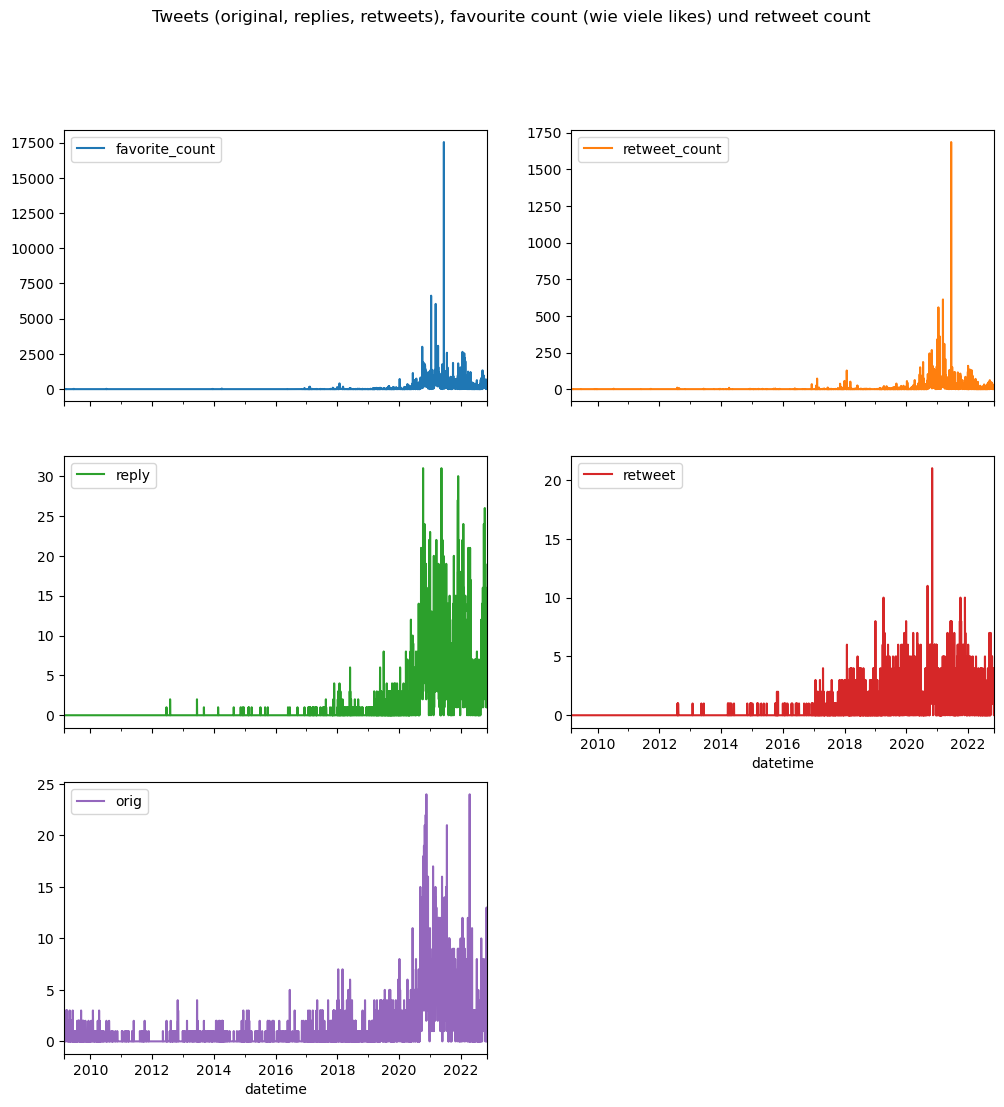

In [36]:
analysis_and_save(df_karpi,"karpi")


In [43]:
dataframe_days_months_heatmap(tweets_karpi, "karpi")

In [44]:
dataframe_hours_months_heatmap(tweets_karpi, "karpi")

In [ ]:
count_and_plot_top50words("karpi", tweets_karpi)

In [ ]:
count_and_plot_top50users("karpi", tweets_karpi)

In [ ]:
count_and_plot_top50hashtags("karpi", tweets_karpi)

In [ ]:
count_words_by_year(tweets_karpi,"karpi")

### Patrizia Laeri

In [45]:
tweets_laeri = load_tweets_from_js("data_twitter_laeri/tweets.js")

Loaded 5159 tweets


In [ ]:
keys_list = ["full_text","favorite_count","created_at","retweet_count"]

tweet_dict_laeri = create_custom_dictionary(tweets_laeri, keys_list)

In [ ]:
df_laeri = create_pandas_dataframe(tweet_dict_laeri)

In [ ]:
analysis_and_save(df_laeri, "laeri")


In [46]:
dataframe_days_months_heatmap(tweets_laeri, "laeri")

In [47]:
dataframe_hours_months_heatmap(tweets_laeri, "laeri")

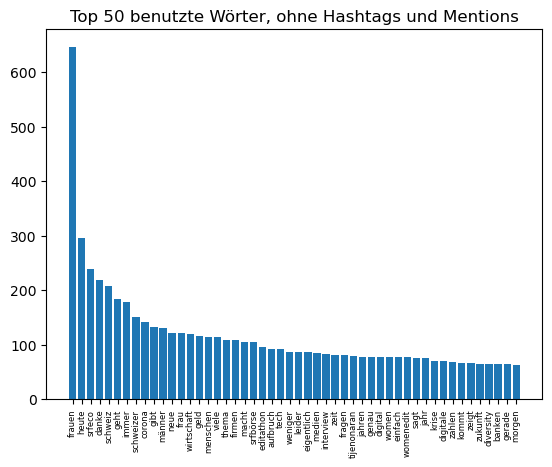

In [88]:
count_and_plot_top50words("laeri", tweets_laeri)

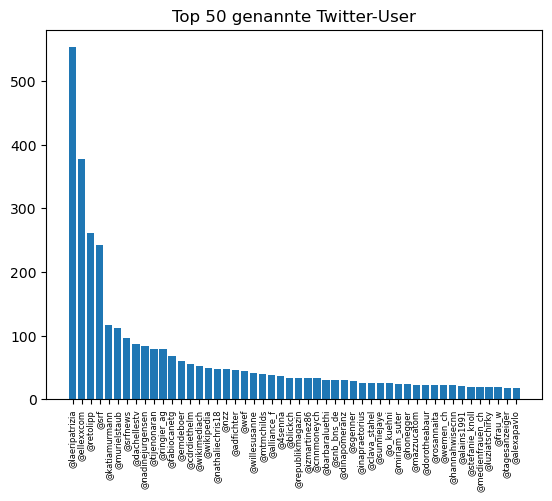

In [89]:
count_and_plot_top50users("laeri", tweets_laeri)

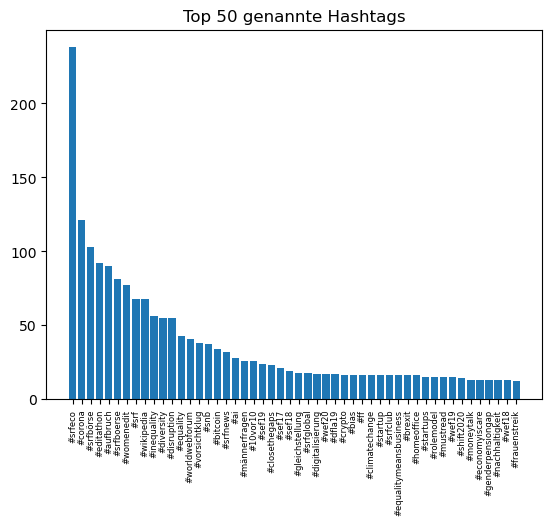

In [90]:
count_and_plot_top50hashtags("laeri", tweets_laeri)

In [ ]:
count_words_by_year(tweets_laeri, "laeri")

### Andri Silberschmidt

In [58]:
tweets_silberschmidt = load_tweets_from_js("archiv_silberschmidt/data/tweets.js")

Loaded 4008 tweets


In [60]:
keys_list = ["full_text","favorite_count","created_at","retweet_count"]

tweet_dict_silberschmidt = create_custom_dictionary(tweets_silberschmidt, keys_list)

In [61]:
df_silberschmidt = create_pandas_dataframe(tweet_dict_silberschmidt)

/var/folders/6z/gpk4kkhj5jzgy7n_k5391sfh0000gn/T/ipykernel_9461/291534932.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets_per_month = df.groupby(pd.Grouper(freq='M')).sum()
/var/folders/6z/gpk4kkhj5jzgy7n_k5391sfh0000gn/T/ipykernel_9461/291534932.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets_per_day = df.groupby(pd.Grouper(freq='d')).sum()


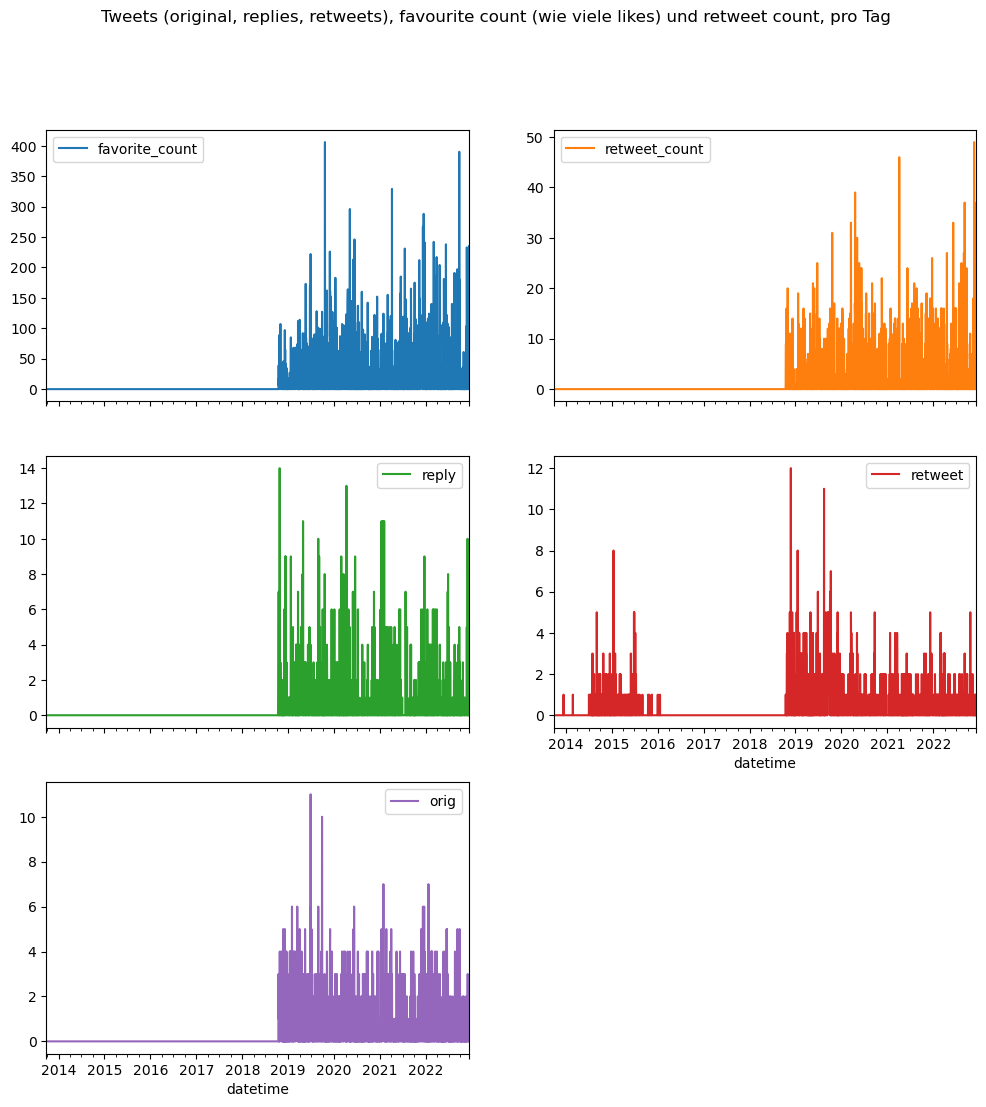

In [62]:
analysis_and_save(df_silberschmidt, "silberschmidt")


In [75]:
dataframe_days_months_heatmap(tweets_silberschmidt, "silberschmidt")

In [76]:
dataframe_hours_months_heatmap(tweets_silberschmidt, "silberschmidt")

In [ ]:
count_and_plot_top50words("silberschmidt", tweets_silberschmidt)

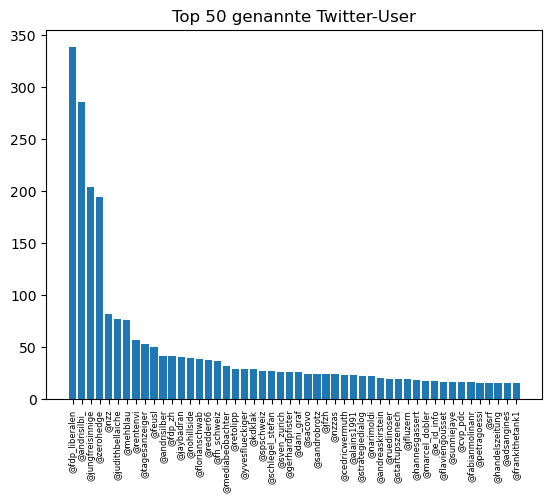

In [71]:
count_and_plot_top50users("silberschmidt", tweets_silberschmidt)

In [ ]:
count_and_plot_top50hashtags("silberschmidt", tweets_silberschmidt)

**Andri Silberschmidt hat alte Tweets zum Teil gelöscht** deshalb gibt es nicht für alle Jahre ein Top20. Workaround: Zuerst Dict basteln, dann alte Jahre löschen und erst danach ein Pandas-Dataframe erstellen

In [ ]:

words_by_year = {}
def count_words_by_year_return_dict(tweets):
      
    """
    dict mit Jahr und Wörtern
    key: jahr
    value: wörter und verwendung
    """
    years = []
    for tweet in tweets:
        year = tweet["timestamp"].strftime("%Y")
        years.append(year)
    
    years = sorted(list(set(years)))
    print(years)
    
    filter_list = get_users(tweets) + get_hashtags(tweets)

    
    for year in years:
        c = Counter()
        for tweet in tweets:
            if year == tweet["timestamp"].strftime("%Y"):
                for word in get_words(tweet["tweet"]["full_text"]):
                    if word not in stopwords:
                        if word not in stopworte:
                            if word not in filter_list:
                                c[word] += 1
        words_by_year[year] = c
    return(words_by_year)
    

In [ ]:
df_words_years_silberschmidt = count_words_by_year_return_dict(tweets_silberschmidt)

In [ ]:
a = {}
for key in df_words_years_silberschmidt:
   # print(key)
   # print(words_by_year_laeri[key].most_common(20))
    if key > "2017":
        a[key] = words_by_year[key].most_common(20)
a = pd.DataFrame(a)
a.reindex(sorted(a.columns), axis=1)
#return(a)

df_ab2018_words_years_silberschmidt = a
df_ab2018_words_years_silberschmidt.to_csv("silberschmidt_wörter_pro_jahr.csv")


### Emma Hodcroft

In [66]:
tweets_hodcroft = load_tweets_from_js("archive_firefox66/data/tweets.js")

Loaded 12441 tweets


In [67]:
keys_list = ["full_text","favorite_count","created_at","retweet_count"]

tweet_dict_hodcroft = create_custom_dictionary(tweets_hodcroft, keys_list)

In [68]:
df_hodcroft = create_pandas_dataframe(tweet_dict_hodcroft)

/var/folders/6z/gpk4kkhj5jzgy7n_k5391sfh0000gn/T/ipykernel_10659/291534932.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets_per_month = df.groupby(pd.Grouper(freq='M')).sum()
/var/folders/6z/gpk4kkhj5jzgy7n_k5391sfh0000gn/T/ipykernel_10659/291534932.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets_per_day = df.groupby(pd.Grouper(freq='d')).sum()


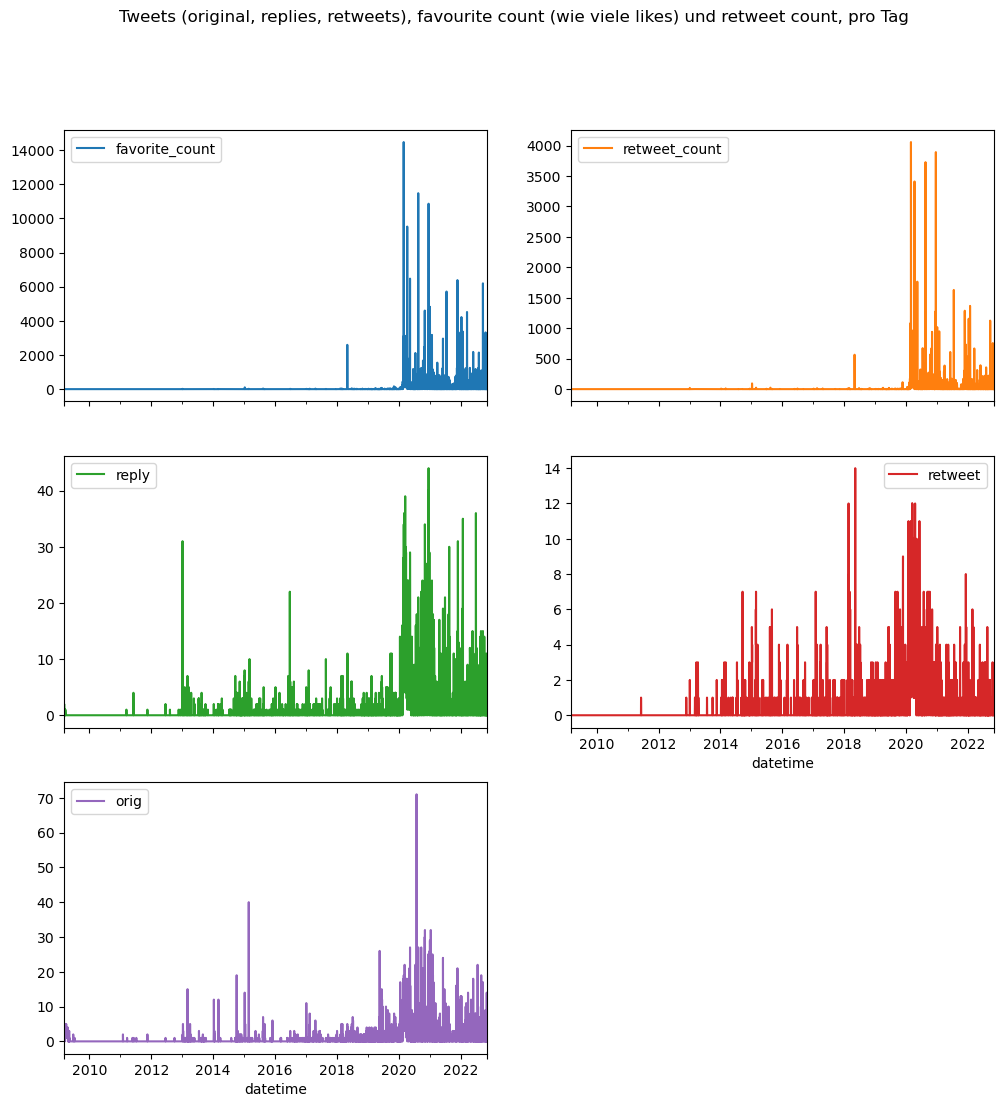

In [69]:
analysis_and_save(df_hodcroft, "hodcroft")


In [70]:
dataframe_days_months_heatmap(tweets_hodcroft, "hodcroft")

In [71]:
dataframe_hours_months_heatmap(tweets_hodcroft, "hodcroft")

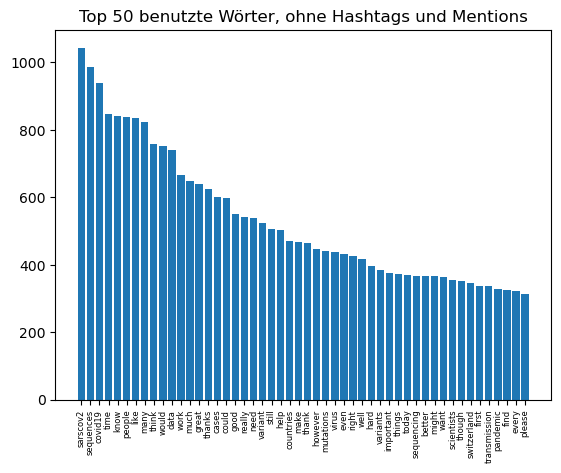

In [72]:
count_and_plot_top50words("hodcroft", tweets_hodcroft)

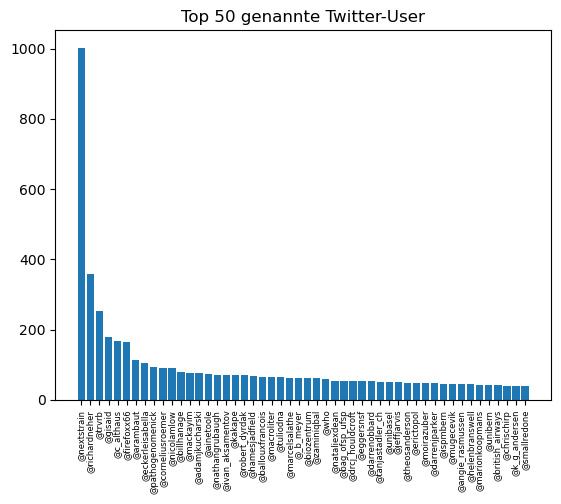

In [73]:
count_and_plot_top50users("hodcroft", tweets_hodcroft)

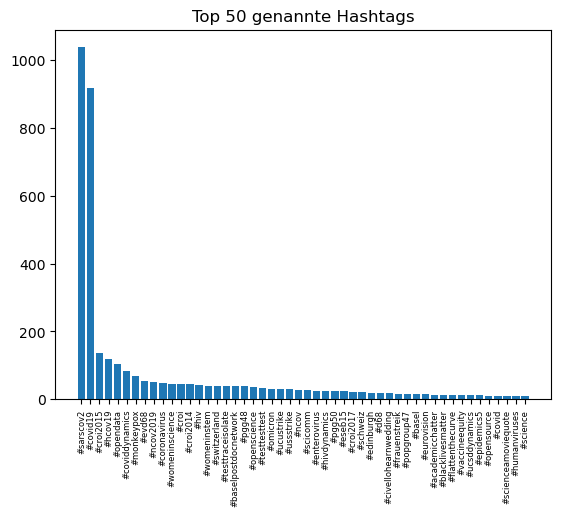

In [74]:
count_and_plot_top50hashtags("hodcroft", tweets_hodcroft)

In [75]:
count_words_by_year(tweets_hodcroft, "hodcroft")

['2009', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']


## Quellen:

- Wichtigste Inspirationsquelle, einiges mit Bearbeitung übernommen: https://github.com/dangoldin/twitter-archive-analysis

## Appendix

Diese Funktionen könnten für die Darstellung eventuell noch interessant sein, kopiert von https://github.com/dangoldin/twitter-archive-analysis

In [ ]:
def by_minute(tweets):
    minutes =[]
    for tweet in tweets:
        minutes.append(tweet["timestamp"].minute)
        


    fig = plt.figure()
    ax = fig.add_subplot(111)

    n, bins = np.histogram(minutes, range(61))

    print(n, bins)

    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n

    # we need a (numrects x numsides x 2) numpy array for the path helper
    # function to build a compound path
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    # get the Path object
    barpath = path.Path.make_compound_path_from_polys(XY)

    # make a patch out of it
    patch = patches.PathPatch(barpath, facecolor="blue", edgecolor="gray", alpha=0.8)
    ax.add_patch(patch)

    # update the view limits
    ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())

    # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xticks(range(0, 60), ha="center", rotation="vertical", fontsize="8")

    plt.xlabel("Minutes")
    plt.ylabel("# Tweets")
    plt.title("# of Tweets by Minute")

    # SPEICHERN
    #plt.savefig(os.path.join(out_dir, "by-hour.png"), bbox_inches=0)
    
    
    plt.show()

In [ ]:
def by_hour(tweets, out_dir):
    hours = []
    for tweet in tweets:
        hours.append(tweet["timestamp"].hour)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    n, bins = np.histogram(hours, range(25))

    print(n, bins)

    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n

    # we need a (numrects x numsides x 2) numpy array for the path helper
    # function to build a compound path
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    # get the Path object
    barpath = path.Path.make_compound_path_from_polys(XY)

    # make a patch out of it
    patch = patches.PathPatch(barpath, facecolor="blue", edgecolor="gray", alpha=0.8)
    ax.add_patch(patch)

    # update the view limits
    ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())

    # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xticks(range(0, 24), ha="center")

    plt.xlabel("Hour")
    plt.ylabel("# Tweets")
    plt.title("# of Tweets by Hour")

    # SPEICHERN
    #plt.savefig(os.path.join(out_dir, "by-hour.png"), bbox_inches=0)
    
    plt.show()

In [ ]:
def by_day_of_week(tweets, out_dir):
    dow = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
    c = Counter()
    for tweet in tweets:
        c[tweet["timestamp"].strftime("%A")] += 1
    print(c.most_common(10))

    N = len(dow)

    ind = np.arange(N)
    width = 0.9

    fig = plt.figure()
    ax = fig.add_subplot(111)

    rects1 = ax.bar(0.05 + ind, [c[d] for d in dow], width, color="b")

    ax.set_ylabel("# Tweets")
    ax.set_title("Tweets by Day of Week")
    ax.set_xticks(ind + 0.5 * width)
    ax.set_xticklabels([d[:3] for d in dow])

    #plt.savefig(os.path.join(out_dir, "by-dow.png"), bbox_inches=0)
    xplt.show()

In [ ]:
#by_day_of_week(tweets_laeri, "outdir")